# SOM/HAC implementation using sklearn
### Created: 5/16/2024 by Haley Synan

#### Step 1: Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import preprocessing
from mpl_toolkits.basemap import Basemap
from sklearn_som.som import SOM
from pandas import *
from scipy.cluster.hierarchy import linkage, dendrogram


#### Step 2: Read in, normalize data, and format data for input into SOM

In [8]:
# reading CSV file
dt = read_csv("data_all_nonan.csv")
#[:N] is the syntrax to read the first N rows of a column 
N = 50

#format data 
n_lat = preprocessing.normalize([dt.lat[:N]])
n_lat = n_lat.transpose()
#lon = np.array(dt.lon[:N])
n_lon = preprocessing.normalize([dt.lon[:N]])
n_lon = n_lon.transpose()
n_mlp = preprocessing.normalize([dt.mlp2[:N]])
n_mlp = n_mlp.transpose()
n_spic = preprocessing.normalize([dt.spiciness0[:N]])
n_spic = n_spic.transpose()

#data = np.concatenate(n_lat,n_lon)
data = np.hstack([n_lat,n_lon, n_mlp, n_spic])

dimensions = data.shape
rows, num_var = dimensions
print(num_var)

4


#### Step 4: Train SOM
##### **m,n**: map dimensions
##### **dim** = number of features (variables)
##### **random_state** = Optional integer seed to the random number generator for weight initialization. This will be used to create a new instance of Numpy’s default random number generator (it will not call np.random.seed()). Specify an integer for deterministic results.
##### **max_iter**: number of iterations before completing training
##### **lr**: The initial step size for updating the SOM weights (default =1)
##### **sigma**: Optional parameter for magnitude of change to each weight. Does not update over training (as does learning rate). Higher values mean more aggressive updates to weights.

In [9]:
m_i = 20*25
som = SOM(m=20, n=25, dim=num_var, sigma=2, random_state=2, max_iter=8000)

# Fit it to the data
som.fit(data)

# Assign each datapoint to its predicted cluster
predictions = som.predict(data)
pred = predictions.reshape(N,1)
#print(pred)

#### Step 5: Visualize SOM nodes on data 
##### Plot data with their best matching SOM node 

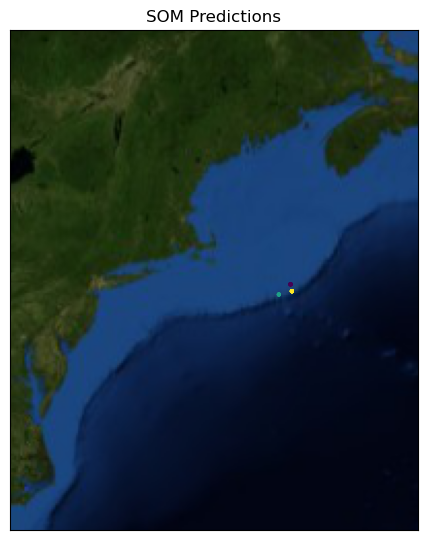

In [10]:
#data for scatter plot
lats = dt.lat[:N]
lons = dt.lon[:N]

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=34, urcrnrlat=47, \
            llcrnrlon=-77, urcrnrlon=-63, \
            lat_ts=20, \
            resolution='l')
m.bluemarble(scale=1)
#m.shadedrelief(scale=1) # full scale will be overkill
#m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, c=predictions,s=4)
plt.title('SOM Predictions')
plt.show()

##### Visualize SOM nodes on T-S plot
##### Plot temperature and salinity data according to their best matching SOM node

Text(0, 0.5, 'Temperature (C)')

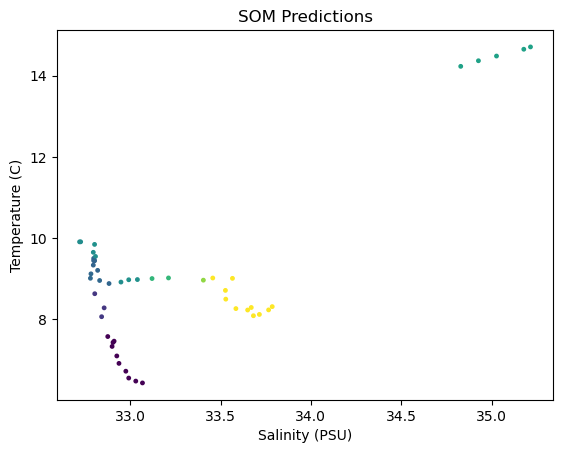

In [11]:
plt.scatter(dt.sal[:N], dt.temp[:N], c=predictions, s=6)
plt.title('SOM Predictions')
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (C)")

#### Step 6: HAC of SOM nodes
##### Further cluster the SOM nodes using hierarchical agglomerative clustering 

In [15]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5).fit(pred)
clustering.labels_

array([0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 2, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4], dtype=int64)

#### Step 7: Visualize final clusters

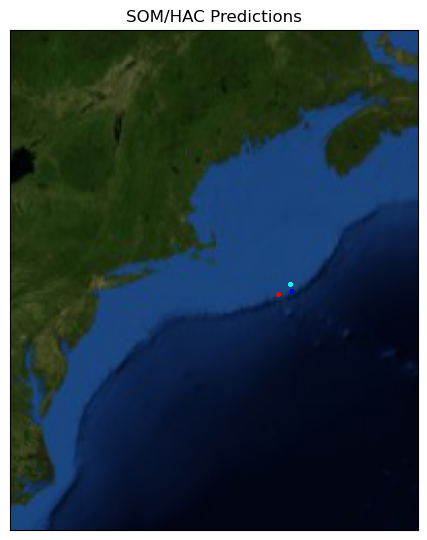

In [16]:
#colors = ['red', 'green', 'blue']
colors = ['red','green','blue','purple','orange','yellow','pink','cyan']
#data for scatter plot
lats = dt.lat[:N]
lons = dt.lon[:N]

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=34, urcrnrlat=47, \
            llcrnrlon=-77, urcrnrlon=-63, \
            lat_ts=20, \
            resolution='l')

m.bluemarble(scale=1)
#m.shadedrelief(scale=1) # full scale will be overkill
#m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, c=clustering.labels_,cmap=ListedColormap(colors),s=4) #cmap=ListedColormap(colors),
plt.title('SOM/HAC Predictions')
plt.show()

Text(0, 0.5, 'Temperature (C)')

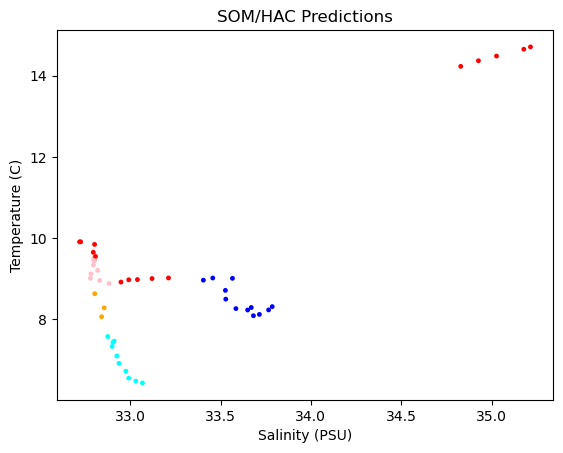

In [17]:
plt.scatter(dt.sal[:N], dt.temp[:N], c=clustering.labels_,  cmap=ListedColormap(colors),s=6)
plt.title('SOM/HAC Predictions')
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (C)")

<font color='red'>
notes: 
    
-can you quantify error of SOM using sklearn? (if not-- not a great package, look elsewhere)

-increase resolution of blue marble? 

-!!preprocessing of data (normalizing, cleaning)

-more visualizing 

-CANT HAVE NAN

-MEMORY ISSUES


In [ ]:
avgsilh = sk.metrics.silhouette_score(pred, clustering.labels_)
print('The silhouette score is ' + str(avgsilh))
#print('The silhouette score is' + avgsilh)

#from yellowbrick.cluster import SilhouetteVisualizer
#visualizer = SilhouetteVisualizer(clustering, colors ='yellowbrick') 
#visualizer.fit(pred)
#cant visualize silhouette plots using HAC but CAN with kmeans 


#### Calinski Harabasz Score
Calinski-Harabasz Score is used to evaluate a model when using unsupervised clustering (when no "true" labels are known) 

Class: internal cluster validation 

CHI (also called variance ratio criterion) "is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Here cohesion is estimated based on the distances from the data points in a cluster to its cluster centroid and separation is based on the distance of the cluster centroids from the global centroid" (gfg).
"Higher value of CH index means the clusters are dense and well separated, although there is no “acceptable” cut-off value. We need to choose that solution which gives a peak or at least an abrupt elbow on the line plot of CH indices. On the other hand, if the line is smooth (horizontal or ascending or descending) then there is no such reason to prefer one solution over others" (gfg).

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
chi = metrics.calinski_harabasz_score(pred, clustering.labels_)
print('The Calinski Harabasz Index is ' + str(chi))

#### Davies Bouldin Score
Davies-Bouldin Index is used to evaluate a model when using unsupervised clustering (when no "true" labels are known) 
The lower the index, the better the separation between the clusters 

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible sco. Values closer to 0 represent a better score

(Definition from https://scikit-learn.org/stable/modules/clustering.html#visualization-of-cluster-hierarchy) 
ns.

In [ ]:
from sklearn.metrics import davies_bouldin_score
db = davies_bouldin_score(pred, clustering.labels_)
print('The silhouette score is ' + str(db))

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(pred, method="complete", metric="euclidean")
dendrogram(complete_clustering)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
cluster_labels = cut_tree(complete_clustering, n_clusters=2).reshape(-1, )
#pred["Cluster"] = cluster_labels


#sns.boxplot(x='Cluster', y='sal', data=pred)